In [2]:
import cv2, time, os, numpy as np
import time
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import get_file 

np.random.seed(123)
# https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API
classFile ="../coco.names" 
threshold = 0.5
is_tensorflow_model=False
perf = []


## methods declaration

### utils methods

In [3]:
def readClasses( classesFilePath,is_yolo=False): 
    global classesList
    global colorList
    global classAllowed
    classAllowed=[0,1,2,3,5,6,7]
    
    with open(classesFilePath, 'r') as f:
        classesList = f.read().splitlines()
        
    #   delete all class except person and vehiccule 
    classesList=classesList[0:8]
    classesList.pop(4)
    print(classesList)
    
   
    # Colors list 
    colorList =  [[23.82390253, 213.55385765, 104.61775798],
       [168.73771775, 240.51614241,  62.50830085],
       [  3.35575698,   6.15784347, 240.89335156],
       [235.76073062, 119.16921962,  95.65283276],
       [138.42940829, 219.02379358, 166.29923782],
       [ 59.40987365, 197.51795215,  34.32644182],
       [ 42.21779254, 156.23398212,  60.88976857]]
    
    if is_yolo==False:
        classesList.insert(0,-1)
        colorList.insert(0,-1)
    # np.random.uniform(low=0, high=255, size=(len(classesList), 3))

### init model methods 

In [4]:
def init_download_model_tensorflow( modelURL):
    fileName = os.path.basename(modelURL) 
    global modelName
    global cacheDir
    global model
    global is_tensorflow_model
    is_tensorflow_model=True
    modelName = fileName[:fileName.index('.')]
    cacheDir = os.path.join("..","tensorflow_model", modelName)

    os.makedirs(cacheDir, exist_ok=True)
    get_file(fname=fileName,origin=modelURL, cache_dir=cacheDir, cache_subdir="checkpoints",  extract=True)
    tf.keras.backend.clear_session()
    model = tf.saved_model.load(os.path.join(cacheDir, "checkpoints", modelName, "saved_model"))
    print("Model " + modelName + " loaded successfully...")
    readClasses(classFile,is_yolo=False)


In [5]:
def init_model_yolo(modelName_="yolov4"):
    global model
    global classFile
    global configPath
    global modelPath
    global modelName
    global is_tensorflow_model

    modelName=modelName_
    is_tensorflow_model=False
    configPath=os.path.join("../opencv_model",modelName,modelName+".cfg")
    modelPath=os.path.join("../opencv_model",modelName,modelName+".weights")
    
    net = cv2.dnn.readNet(modelPath,configPath)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)

    model=cv2.dnn_DetectionModel(net)
    model.setInputParams(size=(416, 416), scale=1/255, swapRB=True)

    readClasses(classFile,is_yolo=True)
     

In [34]:
def init_model_opencv(modelName_="ssd_mobilenet_v3_large_coco_2020_01_14"):
    global model
    global classFile
    global configPath
    global modelPath
    global modelName
    global is_tensorflow_model
    modelName=modelName_
    is_tensorflow_model=False

    configPath=os.path.join("../opencv_model",modelName,modelName+".pbtxt")
    modelPath=os.path.join("../opencv_model",modelName,"frozen_inference_graph.pb")
    model=cv2.dnn_DetectionModel(modelPath,configPath)

    # model.setInputSize(1200,801)
    model.setInputSize(320,320)
    model.setInputScale(1.0/127.5)
    model.setInputMean((127.5,127.5,127.5))
    model.setInputSwapRB(True)
    readClasses(classFile)
    

### detection methodes

In [53]:
def imageDetectionTensorflow( image,threshold= 0.5,videoFrame=False,imagePath=None,setSoftNMS=False):
    global model
    global classesList
    global colorList
    global detections

    inputTensor = cv2.cvtColor( image.copy(), cv2.COLOR_BGR2RGB ) 
    inputTensor = tf.convert_to_tensor(inputTensor, dtype=tf.uint8) 
    inputTensor = inputTensor[tf.newaxis,...]

    s = time.time()
    detections = model(inputTensor)
    curr_time = (time.time()-s )*1000
    if videoFrame==False :
        print(modelName )
        print("execution time : ",str(curr_time))
    
    bboxs = detections['detection_boxes'][0].numpy()
    classIndexes = detections['detection_classes'][0].numpy().astype(np.int32) 
    classScores = detections['detection_scores'][0].numpy()
    imH, imW, imC = image.shape

    if setSoftNMS :
        bboxIdx = tf.image.non_max_suppression_with_scores(bboxs, classScores, max_output_size=150, 
        iou_threshold=threshold, soft_nms_sigma=threshold)
    else :
        bboxIdx = tf.image.non_max_suppression(bboxs, classScores, max_output_size=150, 
        iou_threshold=threshold, score_threshold=threshold)

    if imagePath != None:
        print("add pref")
        imagePerf={"framework":"Tensorflow","imagePath":imagePath,"exec_time":curr_time,"modelName":modelName,"object_detected":len(bboxIdx)}
        perf.append(imagePerf)

    if len(bboxIdx) != 0: 
        for i in bboxIdx:
            bbox = tuple(bboxs[i].tolist())
            classConfidence = round(100*classScores[i])
            classIndex = classIndexes[i]

            if (classIndex in classAllowed)==False:
                continue

            classLabelText=classesList[classAllowed.index(classIndex)]
            classColor = colorList[classAllowed.index(classIndex)]

            # classColor = colorList[classIndex]
            displayText = '{}: {}'.format(classLabelText, classConfidence) 
            ymin, xmin, ymax, xmax = bbox
            xmin, xmax, ymin, ymax = (xmin * imW, xmax * imW, ymin * imH, ymax * imH) 
            xmin, xmax, ymin, ymax = int(xmin), int(xmax), int(ymin), int(ymax)

            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=classColor, thickness=2) 
            cv2.putText(image, displayText, (xmin, ymin - 10), cv2.FONT_HERSHEY_PLAIN, 1, classColor, 2)
            ###############################################
    return image

In [54]:
def BBoxTensorflow( image,threshold= 0.5,videoFrame=False,imagePath=None):
  
    inputTensor = cv2.cvtColor( image.copy(), cv2.COLOR_BGR2RGB ) 
    inputTensor = tf.convert_to_tensor(inputTensor, dtype=tf.uint8) 
    inputTensor = inputTensor[tf.newaxis,...]

    s = time.time()
    detections = model(inputTensor)
    curr_time = (time.time()-s )*1000
    print(modelName )
    print("execution time : ",str(curr_time))
    
    bboxs = detections['detection_boxes'][0].numpy()
    classIndexes = detections['detection_classes'][0].numpy().astype(np.int32) 
    classScores = detections['detection_scores'][0].numpy()
    bboxIdx = tf.image.non_max_suppression(bboxs, classScores, max_output_size=50, 
    iou_threshold=threshold, score_threshold=threshold)

    if len(bboxIdx) != 0: 
        # for i in bboxIdx:
        i=0
        bbox = bboxs[i].tolist()
        classConfidence = round(100*classScores[i])
        classIndex = classIndexes[i]
        
        print("...bbox from tensorflow")
        print(bbox)
        if (classIndex in classAllowed)==False:
            return None
        classLabelText=classesList[classAllowed.index(classIndex)]
        info=[classLabelText,classConfidence,bbox]
        return info
        
    return None

In [38]:
def imageDetectionOpencv( image, threshold = 0.5,videoFrame=False,imagePath=None,setSoftNMS=False): 
    global model
    global modelName
    global perf

    s = time.time()
    classLabelIDs,confidences,bboxs= model.detect(image,confThreshold=threshold)
    curr_time = (time.time()-s )*1000
    if videoFrame==False :
        print(modelName )
        print("execution time : ",str(curr_time))  
        # print( classLabelIDs)
#         "object count :"
    bboxs=list(bboxs)
    confidences=list(np.array(confidences).reshape(1,-1)[0])
    confidences=list(map(float,confidences))
  
    if setSoftNMS==False: 
        print("<<<NMS Methode>>>")
        bboxIdx=cv2.dnn.NMSBoxes(bboxs,confidences,score_threshold=0.5,nms_threshold=0.5)
    else:
        print("<<<SoftNMS Methode>>>")
        SoftNMSConfidences,bboxIdx=cv2.dnn.softNMSBoxes(bboxs,confidences,score_threshold=0.5,nms_threshold=0.5)
        confidences=list(SoftNMSConfidences)
     
 
    if imagePath != None:
        imagePerf={"framework":"opencv","imagePath":imagePath,"exec_time":curr_time,"modelName":modelName,"object_detected":len(bboxIdx)}
        perf.append(imagePerf)
        
    if len(bboxIdx) !=0 :
        for i in range (0,len(bboxIdx)):
        
            bbox=bboxs[np.squeeze(bboxIdx[i])]
            
            if setSoftNMS==False: 
                classConfidence = confidences[bboxIdx[i]]
            else :
                classConfidence = confidences[i]

            classLabelID=np.squeeze(classLabelIDs[bboxIdx[i]])
    
            if (classLabelID in classAllowed)==False:
                continue

            classLabel=classesList[classAllowed.index(classLabelID)]
            classColor = colorList[classAllowed.index(classLabelID)]
            displayText = '{}: {:.2f}'.format(classLabel, classConfidence) 
#             if videoFrame==False:
#                 print(displayText)
            x,y,w,h=bbox
            cv2.rectangle(image,(x,y),(x+w,y+h),color=classColor,thickness=2)
            cv2.putText(image, displayText, (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, classColor, 2)

        return image
        
    return image

In [10]:
def BBoxOpencv( image, threshold = 0.5,videoFrame=False,imagePath=None): 
  
    s = time.time()
    classLabelIDs,confidences,bboxs= model.detect(image,confThreshold=threshold)
    curr_time = (time.time()-s )*1000
  
    print(modelName )
    print("execution time : ",str(curr_time))  
    print( classLabelIDs)

    bboxs=list(bboxs)
    confidences=list(np.array(confidences).reshape(1,-1)[0])
    confidences=list(map(float,confidences))

    bboxIdx=cv2.dnn.NMSBoxes(bboxs,confidences,score_threshold=0.4,nms_threshold=0.2)


    if len(bboxIdx) !=0 :
        i=0            
        bbox=bboxs[np.squeeze(bboxIdx[i])]
        classConfidence = confidences[np.squeeze(bboxIdx[i])]
        classLabelID=np.squeeze(classLabelIDs[np.squeeze(bboxIdx[i])])

        if (classLabelID in classAllowed)==False:
            return None

        classLabel=classesList[classAllowed.index(classLabelID)]
        print("...bbox from opencv")
        # print(bbox)
        info=[classLabel,classConfidence,bbox]

        return info
        
    return None

In [11]:
def predictImage( imagePath, threshold = 0.5,setSoftNMS=False): 
    global modelName
    image = cv2.imread(imagePath)

    if is_tensorflow_model:
        bboxImage = imageDetectionTensorflow(image, threshold,imagePath=imagePath,setSoftNMS=setSoftNMS)
    else :
        bboxImage = imageDetectionOpencv(image, threshold,imagePath=imagePath,setSoftNMS=setSoftNMS)
    
    pathnew="../output/"+modelName + "_" + imagePath[-5:-4] + ".jpg"
    cv2.imwrite(pathnew, bboxImage) 
    img = cv2.cvtColor(bboxImage, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
    print(modelName + "_" + imagePath[-5:-4]+".jpg")
    cv2.imshow("Result", bboxImage)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 
    
#     global classesList
# print(classesList)

In [12]:
def predictVideo( videoPath, threshold = 0.5): 
    print(modelName )
    print("videoPath : ",str(videoPath))
        
    cap=cv2.VideoCapture(videoPath)
    if ( cap.isOpened()==False):
        print("ERROR opening file ..")
        return
    (success,image)=cap.read()
    startTime=0
    
    while success:
        currentTime=time.time()
        fps=1/(currentTime-startTime)
        startTime=currentTime
        bboxImage= imageDetectionOpencv(image, threshold,videoFrame=True)
        cv2.putText(bboxImage,"FPS : "+str(int(fps)),(20,70),cv2.FONT_HERSHEY_PLAIN,2,(0,255,0),2)
        cv2.imshow("Result",bboxImage)
        
        key=cv2.waitKey(1) & 0xFF
        if key==ord("q"):
            break
            
        (success,image)=cap.read()
    cv2.destroyAllWindows()

##  declare model & test detection 

### construct models

In [63]:
# modelName="ssd_mobilenet_v3_large_coco_2020_01_14"
# ssd_inception_v2_coco_2017_11_17
# ssd_mobilenet_v1_ppn_coco
#faster_rcnn_inception_v2_coco_2018_01_28
init_model_opencv(modelName_="ssd_mobilenet_v3_large_coco_2020_01_14")

['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck']


In [67]:
# https://github.com/AlexeyAB/darknet/wiki/YOLOv4-model-zoo
# yolov7-tiny
# yolov4-tiny
# yolov4-csp
# yolov4
# yolov3
# yolov3-tiny
# yolov2
init_model_yolo(modelName_="yolov4-tiny")

['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck']


In [49]:
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20210210/centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz"
modelURL="http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz"
# modelURL="http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d3_coco17_tpu-32.tar.gz"
init_download_model_tensorflow(modelURL) 

Model faster_rcnn_resnet50_v1_640x640_coco17_tpu-8 loaded successfully...
['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck']


In [ ]:
readClasses(classFile,is_yolo=False)

### TEST FUNCTIONs

yolov4-tiny
execution time :  79.94914054870605
<<<NMS Methode>>>


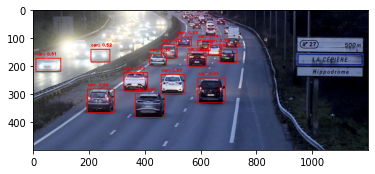

yolov4-tiny_1.jpg


In [69]:
imagePath = "../test/1.jpg"
predictImage( imagePath,threshold=0.5)

yolov4-tiny
execution time :  78.7498950958252
<<<NMS Methode>>>


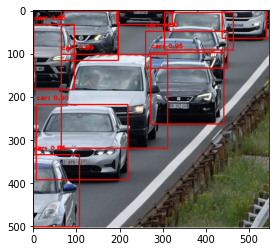

yolov4-tiny_0.jpg


In [74]:
# readClasses(classFile,is_yolo=True)
imagePath = "../test/10.jpg" 
predictImage( imagePath,threshold=0.5)

yolov4-tiny
execution time :  86.05670928955078
<<<NMS Methode>>>


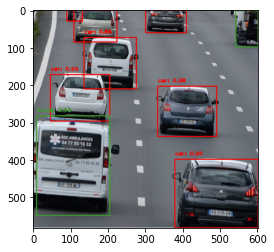

yolov4-tiny_9.jpg


In [73]:
# readClasses(classFile,is_yolo=True)
imagePath = "../test/9.jpg" 
predictImage( imagePath,threshold=0.5)

In [ ]:
# readClasses(classFile,is_yolo=True)
imagePath = "../test/7.jpg" 
predictImage( imagePath,threshold=0.5)

In [ ]:
# readClasses(classFile,is_yolo=True)
imagePath = "../test/8.jpg" 
predictImage( imagePath,threshold=0.5)

In [ ]:
readClasses(classFile,is_yolo=True)
imagePath = "../test/6.jpg" 
predictImage( imagePath,threshold=0.5)

In [ ]:
imagePath = "../test/5.jpg" 
predictImage( imagePath,threshold=0.5)

In [ ]:
imagePath = "../test/4.jpg" 
predictImage( imagePath,threshold=0.5)

In [71]:
videoPath="../test/2.mp4"
predictVideo(videoPath, threshold=0.4)

yolov4-tiny
videoPath :  ../test/2.mp4
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS Methode>>>
<<<NMS 

In [ ]:
perf

## IOU

In [75]:
def readGroundtruthBBox(imagePath):
   bboxFileName = imagePath[:imagePath.rfind('.')]+".bbox"
   with open(bboxFileName, 'r') as f:
      # classesList = f.read().splitlines
      for line in f:
         objects_cord=line.split()
   return objects_cord

In [76]:
def drawGroundtruthBBox(imagePath):
    objects_info=readGroundtruthBBox(imagePath)
    # objects_cord=[int(x) for x in objects_cord]
    objects_cord=objects_info[1::]
    objects_cord=[int(x) for x in objects_cord]
    x,y,w,h=tuple(objects_cord)
    displayText=objects_info[0]
    displayText = '{}: {}'.format(objects_info[0], 'GT') 
    image = cv2.imread(imagePath)
    cv2.rectangle(image,(x,y),(x+w,y+h),color=(57,198,21),thickness=2)
    cv2.putText(image, displayText, (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, (57,198,21), 2)

    plt.imshow(image)
    plt.show()
    cv2.imshow("Result", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 
    # return image

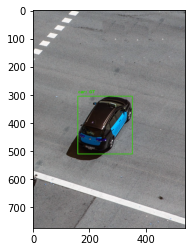

In [77]:
drawGroundtruthBBox("../test/11.jpg")

In [78]:
def drawInferenceOverGroundtruthBBox(imagePath):
    
    image = cv2.imread(imagePath)
    if is_tensorflow_model:
        inferenceImg = imageDetectionTensorflow(image, threshold,imagePath=imagePath)
        inferenceImg = cv2.cvtColor(inferenceImg, cv2.COLOR_BGR2RGB)
    else :
        inferenceImg = imageDetectionOpencv(image, threshold,imagePath=imagePath)
    
    objects_cord=readGroundtruthBBox(imagePath)
    x,y,w,h=(int(objects_cord[1]),int(objects_cord[2]),int(objects_cord[3]),int(objects_cord[4]))
    displayText=objects_cord[0]
    displayText = '{}: {}'.format(objects_cord[0], '[GT]') 
    cv2.rectangle(inferenceImg,(x,y),(x+w,y+h),color=(57,198,21),thickness=2)
    cv2.putText(inferenceImg, displayText, (x, y - 20), cv2.FONT_HERSHEY_PLAIN, 1, (57,198,21), 2)

    cv2.imshow("Result", inferenceImg)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 

In [79]:
drawInferenceOverGroundtruthBBox("../test/11.jpg")

yolov4-tiny
execution time :  77.08382606506348
<<<NMS Methode>>>


In [80]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    boxA[2]=boxA[0]+boxA[2]
    boxA[3]=boxA[1]+boxA[3]
    boxB[2]=boxB[0]+boxB[2]
    boxB[3]=boxB[1]+boxB[3]

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [81]:
def IOU(imagePath):
    
    image = cv2.imread(imagePath)

    if is_tensorflow_model:
        inferenceInfo= BBoxTensorflow(image, threshold,imagePath=imagePath)
    else :
        inferenceInfo= BBoxOpencv(image, threshold,imagePath=imagePath)

    # print(inferenceInfo)
    inferenceBbox=list(inferenceInfo[2])
    # inferenceImg = cv2.cvtColor(inferenceImg, cv2.COLOR_BGR2RGB)
    objects_info=readGroundtruthBBox(imagePath)
    objects_cord=objects_info[1::]
    objects_cord=[int(x) for x in objects_cord]

    print("inferenceBbox :")
    print(inferenceBbox)
    print("GT Bbox :")
    print(objects_cord)
    
    print("IOU :")
    print(bb_intersection_over_union(inferenceBbox,objects_cord))
    drawInferenceOverGroundtruthBBox( imagePath)

In [82]:
# IOU("../test/11.jpg")
IOU("../test/15.jpg")

yolov4-tiny
execution time :  81.05087280273438
[2 2]
...bbox from opencv
inferenceBbox :
[188, 190, 173, 162]
GT Bbox :
[183, 190, 174, 157]
IOU :
0.921377607025247
yolov4-tiny
execution time :  97.30958938598633
<<<NMS Methode>>>


## NMS vs SOFT NMS

In [ ]:
imagePath = "../test/10.jpg" 
predictImage( imagePath,threshold=0.5,setSoftNMS=False)

In [ ]:
imagePath = "../test/7.jpg" 
predictImage( imagePath,threshold=0.5,setSoftNMS=False)

In [ ]:
imagePath = "../test/7.jpg" 
predictImage( imagePath,threshold=0.5,setSoftNMS=True)

In [ ]:
imagePath = "../test/6.jpg" 
predictImage( imagePath,threshold=0.5,setSoftNMS=False)

In [ ]:
imagePath = "../test/6.jpg" 
predictImage( imagePath,threshold=0.5,setSoftNMS=True)

## Threshold Tracker

In [58]:
def predictImageWithTracker( imagePath, threshold = 0.5,setSoftNMS=False): 
    global newDetection   
    global newThreshold   
    newDetection=True
    def onChange(t):
        global newDetection   
        global newThreshold  
        newThreshold= t
        newDetection  =True

    image = cv2.imread(imagePath)
    if is_tensorflow_model:
        bboxImage = imageDetectionTensorflow(image, threshold,imagePath=imagePath,setSoftNMS=setSoftNMS)
    else :
        bboxImage = imageDetectionOpencv(image, threshold,imagePath=imagePath,setSoftNMS=setSoftNMS)
    cv2.namedWindow("Image_Threshold_Tracker")
    cv2.createTrackbar('threshold','Image_Threshold_Tracker',50,100,onChange)
     
    while(1):
        if newDetection :
            newDetection=False
            img = cv2.imread(imagePath)
            if is_tensorflow_model:
                bboxImage = imageDetectionTensorflow(img, (float)(newThreshold/100),imagePath=imagePath,setSoftNMS=setSoftNMS)
            else :
                bboxImage = imageDetectionOpencv(img, (float)(newThreshold/100),imagePath=imagePath,setSoftNMS=setSoftNMS)
            print("===> inference for newThreshold:" + str((float)(newThreshold/100)))
            cv2.imshow("Image_Threshold_Tracker", bboxImage)
        key=cv2.waitKey(1500) & 0xFF
        if key==ord("q"):
            break
    
    pathnew="../output/"+modelName + "_" + imagePath[-5:-4] + ".jpg"
    cv2.imwrite(pathnew, bboxImage) 
    cv2.destroyAllWindows() 



In [62]:
imagePath = "../test/8.jpg" 
predictImageWithTracker( imagePath,threshold=0.5,setSoftNMS=True)

yolov3
execution time :  545.5167293548584
<<<SoftNMS Methode>>>
yolov3
execution time :  551.9149303436279
<<<SoftNMS Methode>>>
===> inference for newThreshold:0.5
yolov3
execution time :  431.05316162109375
<<<SoftNMS Methode>>>
===> inference for newThreshold:0.7
yolov3
execution time :  473.8202095031738
<<<SoftNMS Methode>>>
===> inference for newThreshold:0.9
yolov3
execution time :  454.0712833404541
<<<SoftNMS Methode>>>
===> inference for newThreshold:0.7
